# C3O Paper: Performance Model Evalutation 

In [1]:
import sys
sys.path.insert(0, '..')
import collections

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.display import display, HTML
from ipywidgets import IntProgress

from RuntimePrediction.DefaultModels import (GradientBoosting as GB,
                                             ErnestModel as EM)
from RuntimePrediction.CustomModels import (BasicOptimisticModel as BOM,
                                            OptimisticGradientBoosting as OGB)

## Define Models

In [2]:
Model = collections.namedtuple('Model', ['name', 'predictor', 'kwargs'])

models = [
          Model('Ernest', EM, {}),
          Model('GBM', GB, {}), 
          
          Model('BOM', BOM, {}), 
          Model('OGB', OGB, {}), 
         ]

## Extract Runtime Data

In [3]:
sort_df = pd.read_csv('../data/sort.tsv', sep='\t')
grep_df = pd.read_csv('../data/grep.tsv', sep='\t')
sgd_df = pd.read_csv('../data/sgd.tsv', sep='\t')
kmeans_df = pd.read_csv('../data/kmeans.tsv', sep='\t')
pagerank_df = pd.read_csv('../data/pagerank.tsv', sep='\t')

In [4]:
Job = collections.namedtuple('Job', ['name', 'X', 'y'])

def get_training_data(df, features, filters):
    # Get medians
    g = df.groupby(by=['instance_count','machine_type']+features)
    df = pd.DataFrame(g.median().to_records())
    # Apply filters 
    # e.g. only for one machine type each, the full c3o-experiments were conducted
    # No full cartesian product!
    for k, s, v in filters:
        if s == '==': df = df[df[k] == v] 
        if s == '>' : df = df[df[k] >  v]
    X = df[['instance_count'] + features]
    y = (df[['gross_runtime']]).squeeze()
    return X, y

td = get_training_data
jobs = [
    Job('Sort',
        *(td(sort_df,
            ['data_size_MB'],
            [('machine_type', '==', 'c4.2xlarge'),
             ('line_length', '==', 100)] )) ),
    Job('Grep',
        *(td(grep_df,
            ['data_size_MB', 'p_occurrence'],
            [('machine_type', '==', 'm4.2xlarge')] )) ),
    Job('SGDLR',
        *(td(sgd_df,
            ['observations', 'features', 'iterations'],
            [('machine_type', '==', 'r4.2xlarge'),
             ('instance_count', '>', 2)] )) ),
    Job('K-Means',
        *(td(kmeans_df,
            ['observations', 'features', 'k'],
            [('machine_type', '==', 'r4.2xlarge'),
             ('instance_count', '>', 2)] )) ),
    Job('Page Rank',
        *(td(pagerank_df,
            ['links', 'pages', 'convergence_criterion'],
            [('machine_type', '==', 'r4.2xlarge')] )) ),
]

## Train-Test Split Creations

In [5]:
common_features = {'Grep': ['p_occurrence'],
                   'SGDLR': ['iterations'],
                   'K-Means': ['k'],
                   'Page Rank': ['pages', 'convergence_criterion']}

def get_groups(X, y, common_features):
    # Get groups of observations that share the same value for certain features
    Xy = X.merge(y, right_index=True, left_index=True)
    grouped = Xy.groupby(by=common_features, as_index=True)
    X_keys, y_keys = [k for k in Xy.keys() if k != 'gross_runtime'], ['gross_runtime']
    Xs = [group[X_keys] for name, group in grouped]
    ys = [group[y_keys].squeeze() for name, group in grouped]
    return Xs, ys

In [6]:
def create_global_training_data(job, splits, test_size=.1):
    for _ in range(splits):
        yield train_test_split(job.X,job.y,test_size=test_size)

## Evaluate Models on the Training Datasets and Capture Errors

In [7]:
# Display tables side by side and get rid of horizontal scroll bar under tables
HTML('''<style> \
     .output {flex-direction: row; flex-wrap: wrap} \
     div.output_subarea {padding-left: 0mm; padding-right:3mm} \
     </style>''')

In [8]:
def display_evaluation_counts(model):
    count = 0
    with open('error_distribution.csv') as f:
        for line in f:
            tokens = line.replace('\n','').split(',')
            model_name = tokens[1]
            if model_name == model.name:
                count += len(tokens)-2
    print(model.name, count, '  ')

### Amount of Conducted Experiments Thus Far

In [9]:
for model in models:
    display_evaluation_counts(model)

Ernest 370000   
GBM 370000   
BOM 370000   
OGB 370000   


### Calculating the Model Prediction Errors

In [10]:
def evaluate(model, X_train, X_test, y_train, y_test):
    model_instance = model.predictor(**model.kwargs)
    model_instance.fit(X_train, y_train)
    y_pred = model_instance.predict(X_test)
    errors = (y_pred - y_test)/y_test
    return errors

In [11]:
def create_new_global_evaluations(amount):
    progress_bar = IntProgress(min=0, max=len(jobs)*amount); display(progress_bar)
    with open('error_distribution.csv', 'at') as f:
        for job in jobs:
            for split in create_global_training_data(job, splits=amount):
                for model in models:
                    error = evaluate(model, *split)
                    error = ','.join(str(e) for e in error)
                    f.write(f"{job.name},{model.name},{error}\n")
                progress_bar.value += 1

### Conduct Additional Model Error Experiments

In [12]:
create_new_global_evaluations(amount=0)

IntProgress(value=0, max=0)

### Display the Results

In [13]:
def display_job_evaluation(model):
    results = collections.defaultdict(list)
    with open('error_distribution.csv') as f:
        for line in f:
            tokens = line.replace('\n','').split(',')
            job_name, model_name = tokens[:2]
            errors = list(map(float, tokens[2:]))
            if model_name == model.name:
                results[job_name] += errors
    for job_name in results:
        fig, ax = plt.subplots(1,1)
        ax.hist(results[job_name], bins=100)
        ax.set_xlabel("Relative Error")
        ax.set_ylabel("Occurrences")
        ax.set_title(f'{model.name} on {job_name}')
        plt.show()

### Mean Relative Error Distribution of Models for each Job

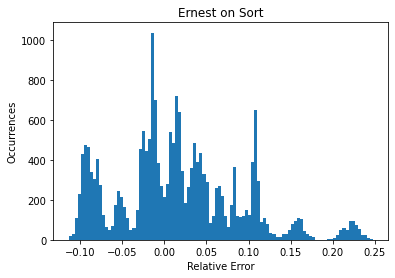

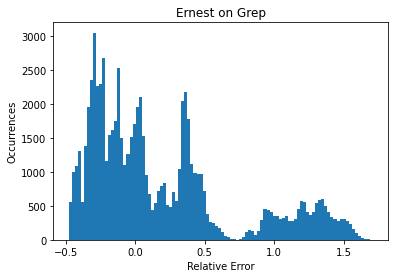

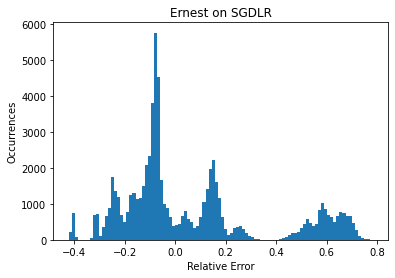

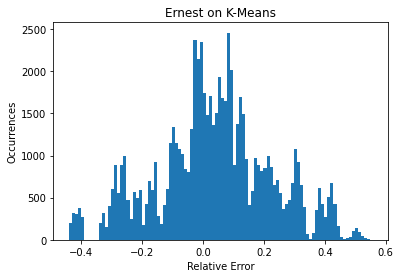

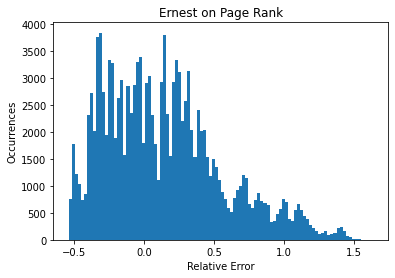

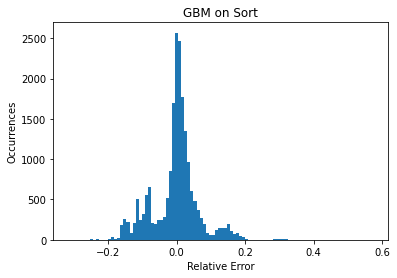

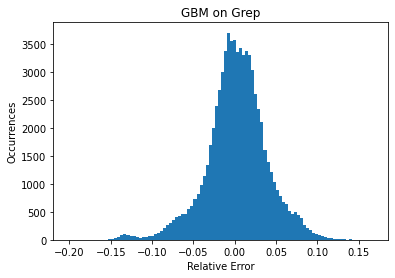

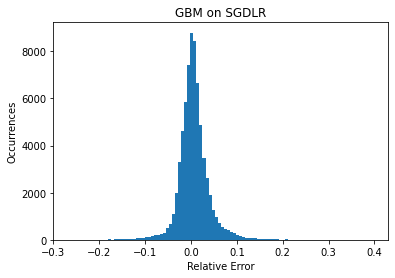

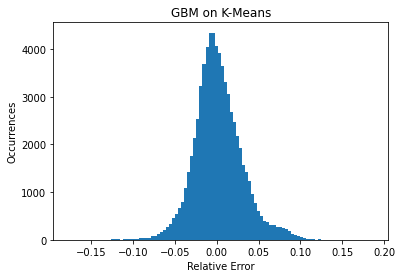

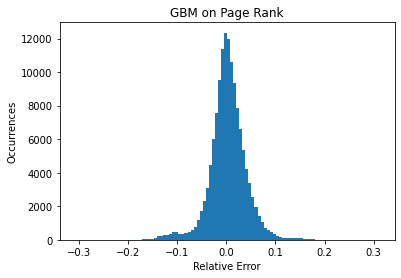

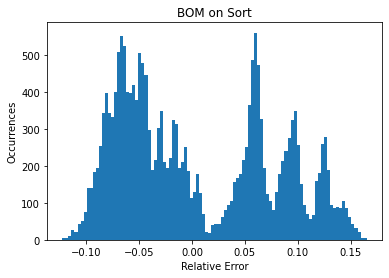

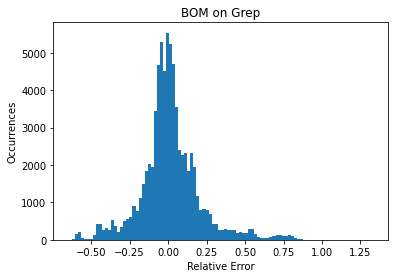

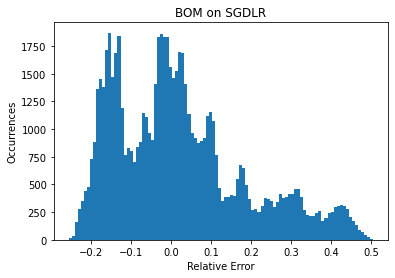

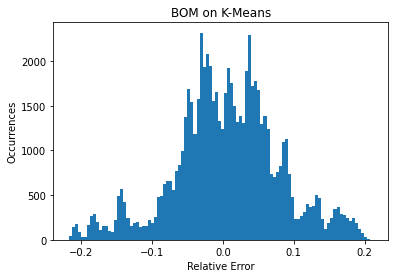

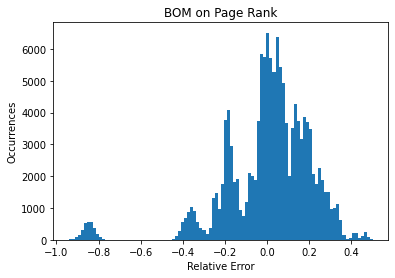

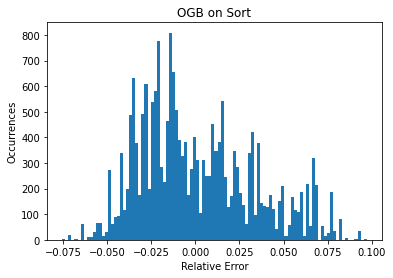

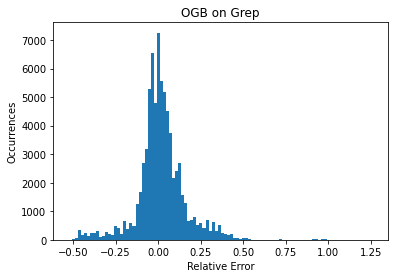

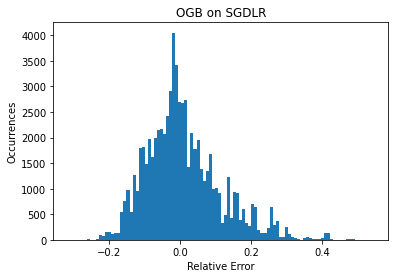

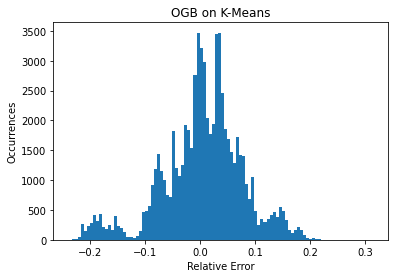

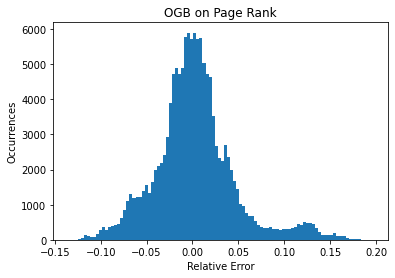

In [14]:
for model in models:
    display_job_evaluation(model)

### Updated Amount of Conducted Experiments per Evaluation Experiments Category

In [15]:
for model in models:
    display_evaluation_counts(model)

Ernest 370000   
GBM 370000   
BOM 370000   
OGB 370000   
